In [1]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
import seaborn as sns

## Location estimation from distributed distance measurements

Earlier in the class, we learned about estimating the distance from an earthquake epicenter to a sensing station using the time difference of arrival for P and S waves. If you missed that, there's a nice overview here: https://www.mtu.edu/geo/community/seismology/learn/earthquake-epicenter/

Here we explore the inverse problem of estimating a location from a series of distance measurements from various sensing stations.

We'll assume we're operating on a plane that goes from 0 to 10 in the X and Y axes. Our sensors will be located at some specified locations (`sensor_xs` and `sensor_ys`) and will make measurements (`measurements`) which may contain some zero-mean, normally-distributed noise (with standard deviation `measurement_std`).

This notebook shows two ways of solving this problem:
1. Using a regularization approach (using the Moore-Penrose pseudoinverse)
2. Using a Bayesian approach to estimate a probability distribution

In [2]:
# This is just a stanardized way to plot the problem at various points in the notebook
def plot_setup(sensor_xs, sensor_ys, measurements, ax=None, true_x=None, true_y=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(10,10))
    
    ax.scatter(sensor_xs, sensor_ys, label='Sensor Locations', c='green', s=100, marker='s')
    
    if true_x and true_y:
        ax.scatter([true_x], [true_y], c='red', s=100, label="True Earthquake Epicenter")

    for x, y, d in zip(sensor_xs, sensor_ys, measurements):
        ax.add_patch(mpatches.Circle((x,y), np.sqrt(d), fill=False, alpha=0.5))

    ax.legend()
    ax.set_xlim([0, 10])
    ax.set_ylim([0, 10])
    
    return ax

## Problem setup

A quick note for clarity: The distance to a source is $\sqrt{(x_{\text{sensor}} - x_{\text{source}})^2 + (y_{\text{sensor}} - y_{\text{source}})^2}$. To avoid repeating a bunch of square and square root operations, we define the measurements as $d^2 = (x_{\text{sensor}} - x_{\text{source}})^2 + (y_{\text{sensor}} - y_{\text{source}})^2$.

<AxesSubplot:>

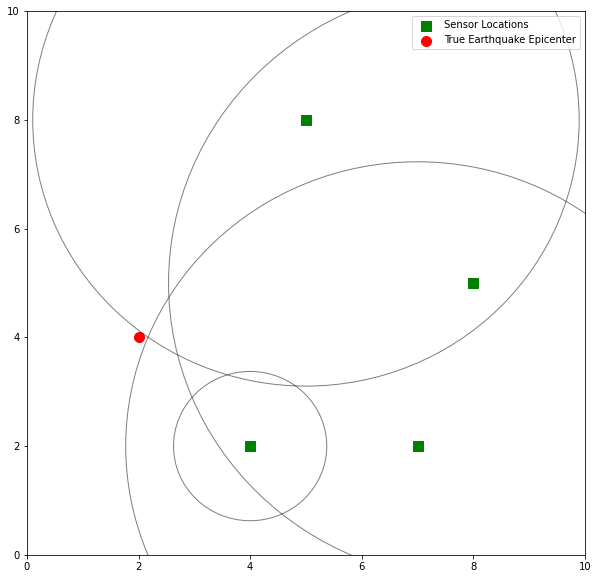

In [3]:
# *** Problem parameters you can adjust ***

true_x, true_y = 2, 4 # True location of the earthquake epicenter

sensor_xs = np.array([4, 5, 8, 7]) # X and Y locations of the measuring stations
sensor_ys = np.array([2, 8, 5, 2])

measurement_std = 5 # Standard deviation of the noise applied to each measurement

# *** Generate the measurements and plot ***

measurements = np.array([(x - true_x)**2 + (y - true_y)**2 for (x,y) in zip(sensor_xs, sensor_ys)]) + measurement_std*np.random.randn(*np.shape(sensor_xs))

plot_setup(sensor_xs, sensor_ys, measurements, true_x=true_x, true_y=true_y)

## "Conventional" linear algebra solution using the matrix inverse or the Moore-Penrose pseudoinverse (L2-norm regularization)

Note: This isn't actually a linear problem. To make this work, we linearize it using an approximation from [Wang, 2015](http://link.springer.com/article/10.1186/s13638-015-0298-1). You can read more about how this works in the "Linear Least Squares Estimation" section here: https://www.thomasteisberg.com/projects/jarvas/

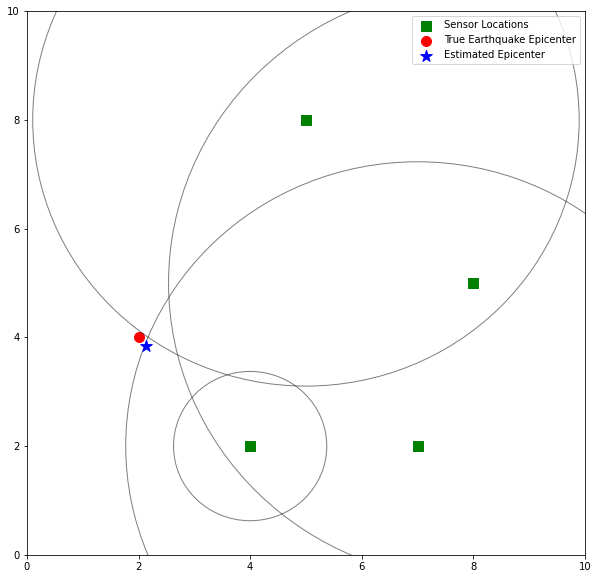

In [4]:
A = np.hstack([-2*np.expand_dims(sensor_xs, 1), -2*np.expand_dims(sensor_ys, 1), np.ones((len(sensor_xs),1))])
b = np.expand_dims(measurements - sensor_xs**2 - sensor_ys**2, 1)

# soln = np.linalg.inv(A) @ b  # *** Matrix inverse *** <- Comment out one at a time
soln = np.linalg.pinv(A) @ b  # *** Pseudoinverse ***

ax = plot_setup(sensor_xs, sensor_ys, measurements, true_x=true_x, true_y=true_y)
ax.scatter([soln[0]], [soln[1]], c='blue', marker='*', s=150, label='Estimated Epicenter')
ax.legend()

## Bayesian inference approach using Markov Chain Monte Carlo

This part uses [PyMC3](https://docs.pymc.io/en/v3/), an awesome library for Bayesian inference and probabilistic programming. Check out the examples on the website and if you really want to dive it, all of the examples/homeworks from Richard McElreath's excellent [Statistical Rethinking](https://xcelab.net/rm/statistical-rethinking/) course/textbook have been [ported to PyMC3](https://github.com/pymc-devs/resources/tree/master/Rethinking_2).

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y, x]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 3 seconds.


<AxesSubplot:>

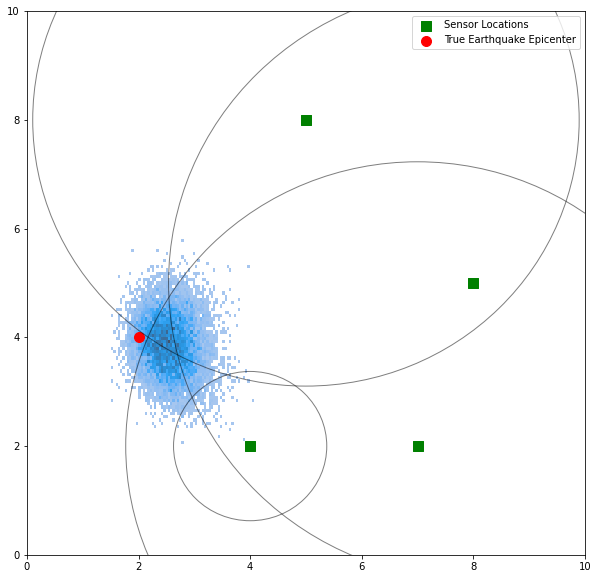

In [5]:
with pm.Model() as m:
    # Priors we define for where we think our epicenter could be - these could be informed, for example, by fault locations.
    # The default ones defined here are fairly weak, but you can play with stronger ones by reducing sigma
    x = pm.Normal("x", 5, sigma=4)
    y = pm.Normal("y", 5, sigma=4)
    
    distances = ((sensor_xs - x) * (sensor_xs - x)) + ((sensor_ys - y) * (sensor_ys - y))
    
    meas_error = pm.Normal("meas_error", mu=distances, sigma=measurement_std, observed=measurements)
    
    trace = pm.sample(3000)
    
fig, ax = plt.subplots(figsize=(10,10))
sns.histplot(x = trace['x'], y = trace['y'], ax=ax)
plot_setup(sensor_xs, sensor_ys, measurements, ax=ax, true_x=true_x, true_y=true_y)